<div id="container" style="position:relative;">
<div style="float:left"><h1>  Final Project - Music Taste Classification </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
<div style="position:relative; float:right"><h4>  Janna Agustin </h4></div>
</div>
</div>

# Introduction

As someone who has grown up surrounded constantly by music, I always wondered what makes up a person's unique "taste" in music. There are the standard forms of describing the music you like – by genre or by artist. But if you explore it further, there are other components involved – lyrics, time period, region of the world, and even musical qualities like BPM, tempo, and key. There are "moods" and "vibes" that are attached to each piece of music and are often subjectively defined by the listener. 

Each individual classifies their music taste in different ways, placing varying levels of value on each of these attributes and others. Some may listen to different types of music for different occasions, others may strictly listen to only one song of a particular genre. There is no one universal method of describing what music you like. This is what makes the task of classifying music taste so difficult. 

In this project, I aim to do a basic exploration of the components that make up an individual's music taste. I will analyze the music data of a friend, Antoine, who uses the popular music streaming platform, Spotify. He has collected 2370 songs over the past few months and has classified each song into one of two categories – liked or disliked. Each song is described by 16 features, generated by Spotify and retrieved using its API. These features include musical measures created by Spotify developers, like "danceability", "liveness" and "speechiness." They also include several musical qualities, like tempo, duration and time signature. In exploring this data and building a basic predictive model, I hope to gain a better understanding of which qualities define an individual's music taste.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection, tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from seaborn import pairplot, heatmap
from mixed_naive_bayes import MixedNB

import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Collection

For a few months, Antoine populated two playlists on Spotify – 'Liked' and 'Disliked' – with songs that, well, he liked and those that he disliked. As an avid music listener, it didn't take very long for the playlists to fill up. 

Once the playlists were sufficiently filled, with around 1000 songs each, I needed to transform them into usable data. Fortunately enough, there exists a lightweight python library called **spotipy**, which allows easy access to the Spotify Web API. With a few lines of code, I was able to extract the songs from the playlists and create a pandas dataframe without any null values. The cleaning was minimal and mostly consisted of changing the data type or unit type of individual features.

Below is the initial dataframe I retrieved, before cleaning.

In [3]:
df = pd.read_csv('music_taste_data.csv', index_col=0)

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,explicit,artists,like
0,0.489,0.516,1,-8.921,0,0.3080,0.4460,0.00000,0.0832,0.172,149.611,95160,4,49,True,['Damso'],1
1,0.662,0.436,9,-12.900,0,0.0651,0.8530,0.00000,0.0624,0.627,92.857,178293,4,48,False,['Jean Leloup'],1
2,0.517,0.928,4,-8.881,0,0.0448,0.0145,0.02330,0.4810,0.728,90.593,172707,4,32,False,['Jean Leloup'],1
3,0.820,0.407,4,-11.301,0,0.0387,0.7710,0.00544,0.1130,0.770,125.642,138027,4,42,False,['Jean Leloup'],1
4,0.452,0.579,2,-11.085,1,0.0476,0.0153,0.89300,0.6370,0.929,84.615,213760,4,62,False,['Khruangbin'],1


## Data Cleaning

#### Artists - a column removed

Initially, the 'artists' column consisted of one long String of all the artist names that appear on the track. I decided to take it out of the dataframe I'm working with in this notebook, in order to simplify the model.

In [4]:
df = df.drop('artists',axis = 1)

#### Explicit - from boolean to numeric

Initially, the 'explicit' column has a data type of Boolean. I switched it in the code below to be integer values – 1 if true, 0 if false.

In [5]:
df['explicit'] = (df['explicit']==True).astype(int)

#### Milliseconds - turned to minutes

Initially, the 'duration_ms' column held the number of milliseconds of each song. I switched it in the code below to be in the unit of minutes, instead of milliseconds.

In [6]:
df['duration_min'] = (df['duration_ms']/(1000*60))%60
df = df.drop('duration_ms',axis = 1)

**There are also no null values:**

In [34]:
df.isnull().any()

danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
time_signature      False
popularity          False
explicit            False
like                False
duration_min        False
dtype: bool

# Data Description


The dataframe has 2370 rows and 16 columns. This means that the dataset includes 2370 songs, each with 15 attributes and one target variable ('like').

In [7]:
df.shape

(2370, 16)

### Columns/Features:

- **Danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- **Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

- **Key:** The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

- **Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

- **Mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music.

- **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- **Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

- **Duration:** The duration of the track in minutes.

- **Time Signature:** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **Popularity:** The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. 

- **Explicit:** Whether or not the track has explicit lyrics ( true = yes it does; false = no it does not OR unknown).



### Target variable:
- **Liked:** indicates whether or not the song is liked by the individual (1 if liked, 0 if disliked)

## Summary Statistics

In [8]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,explicit,like,duration_min
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,0.628254,0.570504,5.318565,-8.780062,0.515612,0.123336,0.343745,0.128071,0.183618,0.477200,116.392002,3.932489,40.466245,0.294937,0.457384,4.020762
std,0.162311,0.207813,3.541736,3.997111,0.499862,0.125918,0.300035,0.272239,0.154587,0.238433,28.181416,0.379508,22.667470,0.456111,0.498286,1.498978
min,0.137000,0.002930,0.000000,-42.238000,0.000000,0.022900,0.000009,0.000000,0.025300,0.032100,48.875000,1.000000,0.000000,0.000000,0.000000,0.385117
25%,0.521250,0.435250,2.000000,-10.424750,0.000000,0.039300,0.068900,0.000000,0.095600,0.279000,93.976750,4.000000,25.000000,0.000000,0.000000,3.199054
50%,0.644000,0.582000,5.000000,-8.024500,1.000000,0.062500,0.272000,0.000112,0.121000,0.472000,115.947000,4.000000,44.000000,0.000000,0.000000,3.745333
75%,0.750000,0.724000,8.000000,-6.224000,1.000000,0.166000,0.579000,0.033025,0.210000,0.662000,133.180500,4.000000,58.000000,1.000000,1.000000,4.499992
max,0.970000,0.994000,11.000000,-1.140000,1.000000,0.957000,0.996000,0.973000,0.992000,0.982000,207.986000,5.000000,93.000000,1.000000,1.000000,29.114733


#### The dataset contains 1084 'liked' songs and 1286 'disliked' songs.

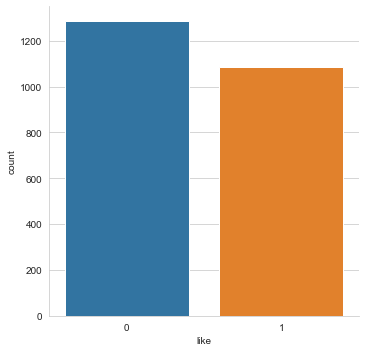

In [9]:
sns.catplot(data = df, x='like', kind='count')

## Visualization

### Pairplots

To illustrate the relationships between certain features, I created pairplots. Since there are 17 features (and creating a 17x17 pariplot graph would not have been useful), I created visualizations for the relationships between features I thought might have been relevant/significant. Below are a few of the pairplots I explored. 

#### Loudness, Energy, Danceability, Tempo

As visualized below, you can see that there is a quadratic relationship between Energy and Loudness. There also seems to be a slightly positive linear relationship between Danceability and Loudness. The other relationships between variables, however, don't seem to have any visible significance. 

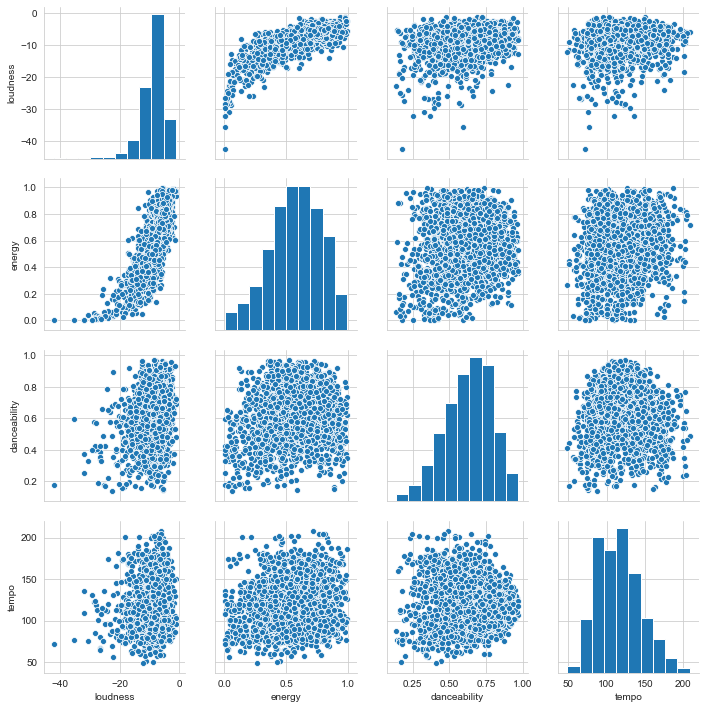

In [11]:
sns.pairplot(df[['loudness', 'energy', 'danceability', 'tempo']])

#### Instrumentalness, Liveness, Acousticness

There doesn't seem to be any visible significance among the relationships between these three features. 

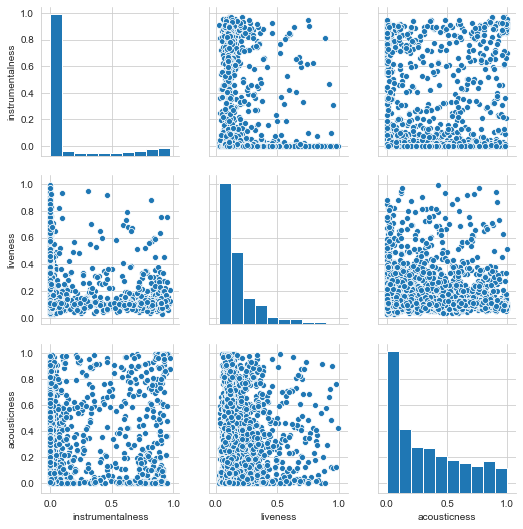

In [12]:
sns.pairplot(df[['instrumentalness', 'liveness', 'acousticness']])

### Correlation

To explore the relations between features further, I decided to create a heatmap of the features' correlation with one another. As indicated by the heatmap, there is a positive correlation between Loudness and Energy, as well as a slightly positive correlation between Speechiness and Explicit, Valence and Energy and Valence and Danceability. There is a strong negative correlation between Acousticness and Energy, as well as between Acousticness and Loudness. There is also a slightly negative correlation between Instrumentalness and Explicit. 

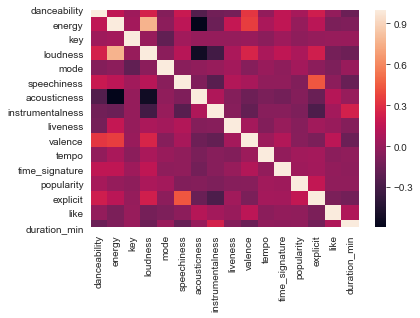

In [13]:
sns.heatmap(df.corr())

### Feature Distributions 


The following histograms display the distribution of values for each feature in the dataset. 

One key observation I have from the histograms below is that quite a few of the distributions for features are right-skewed. These features include speechiness, acousticness, instrumentalness, liveness, tempo and popularity. To be right-skewed means that both the median and the mean of the distribution are to the right of the mode (peak of the graph). It also means that for the measures that are scores from 0 to 1 (speechiness, acousticness, instrumentalness, and liveness), there are more songs that have lower scores and are closer to 0. For tempo it means that most songs in the dataset have lower tempo. For popularity, it means that most songs in the dataset have a lower popularity score.

One exception is the loudness feature, whose graph is left-skewed. This means that most songs in the dataset have higher loudness. 

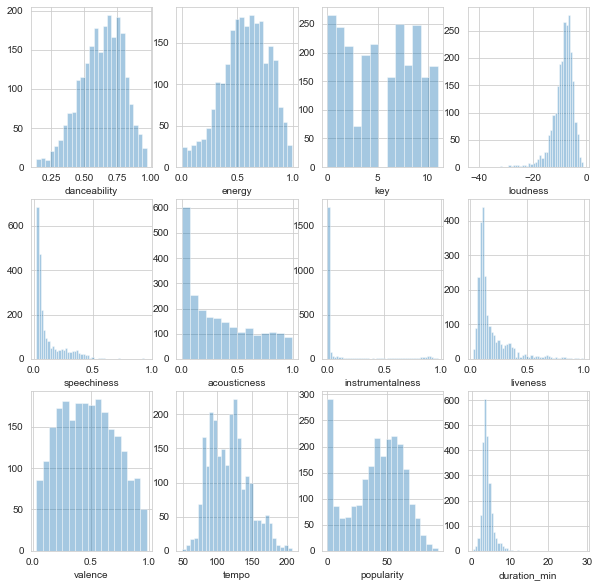

In [14]:
n_row = 3
n_col = 4
num_feat = 0

fig3, ax = plt.subplots(n_row, n_col, figsize=(10,10))

for i in range(n_row):
    for j in range(n_col):
        
        if num_feat==13:
            num_feat+=2
    
        elif num_feat==4 or num_feat == 11:
            num_feat+=1
            
        plot = sns.distplot(df[df.columns[num_feat]], kde=False, ax=ax[i][j])
        plot.set_xlabel(df.columns[num_feat])
        num_feat+=1

fig3.show()

The barplots below show the counts of each categorical value for three features – mode, explicit and time signature. 

The first graph shows that there is roughly the same amount of songs in the dataset that have a mode of 0 as there are songs with a mode of 1.

The second graph shows that there are more than double the songs that are not explicit than there are songs that are explicit.

Finally, the third graph shows that there are significantly more songs in the dataset of time signature 4:4, than there are songs of the other three time signatures. 

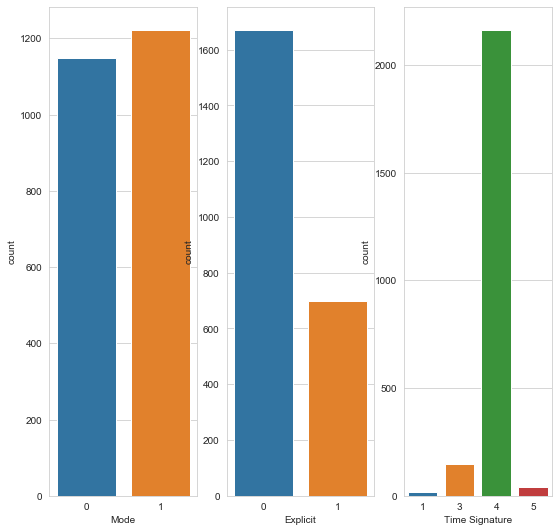

In [15]:
fig_feats_2, ax = plt.subplots(1, 3, figsize=(9, 9))

plot13 = sns.countplot(df['mode'], ax=ax[0])
plot13.set_xlabel('Mode')
plot14 = sns.countplot(df['explicit'], ax=ax[1])
plot14.set_xlabel("Explicit")
plot15 = sns.countplot(df['time_signature'], ax=ax[2])
plot15.set_xlabel("Time Signature")

fig_feats_2.show()

### Difference between Liked songs and Disliked songs

Out of curiosity, I split up the songs from the dataset into those that are liked and those that are disliked. I wanted to see whether the two playlists were made up of songs that differed in the musical qualities/features. While the distribution of the musical features were similar in both the liked songs and disliked songs, there were a few minor differences that I noticed.

Below are the altered histograms, indicating both liked and disliked song distributions, as well as histograms of the features (separated into liked and disliked songs) that I found interesting results in. 

In [16]:
liked = df[df['like']==1]
disliked = df[df['like']==0]

#### Altered Histogram

In general, the distributions of the features for both liked and disliked songs are the same. 

A few observations I have of differences between the two are detailed below. They include the features valence, acousticness, popularity, tempo and duration.

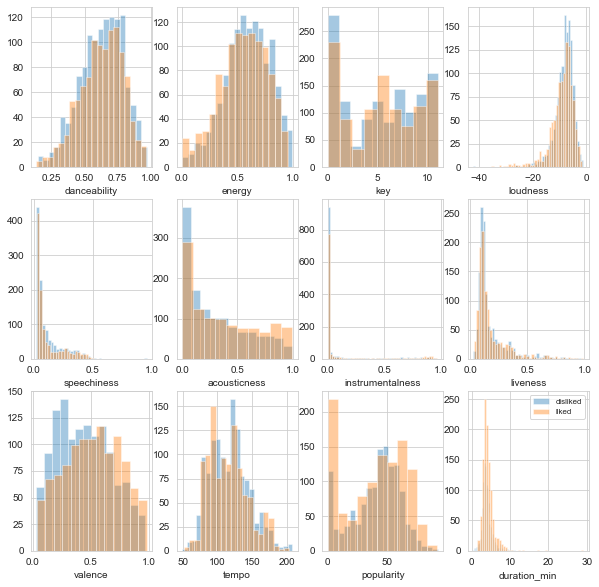

In [17]:
n_row = 3
n_col = 4
num_feat = 0

targets_df = df['like']
targets = {0: 'disliked', 1: 'liked'}

fig3, ax = plt.subplots(n_row, n_col, figsize=(10,10))

for i in range(n_row):
    for j in range(n_col):
        
        if num_feat==13:
            num_feat+=2
    
        elif num_feat==4 or num_feat == 11:
            num_feat+=1
    
        for t, lab  in list(targets.items()):
            plot = sns.distplot(df.as_matrix()[targets_df.as_matrix()==t, num_feat], label=targets[t], kde=False, ax=ax[i][j])
            
        plot.set_xlabel(df.columns[num_feat])
        num_feat+=1

        
plt.legend(loc='upper right', fancybox=True, fontsize=8)
fig3.show()

#### Valence vs. Liked

There are more disliked songs with lower valence (more negative-sounding songs). There are also more liked songs with higher valence (happier-sounding songs).

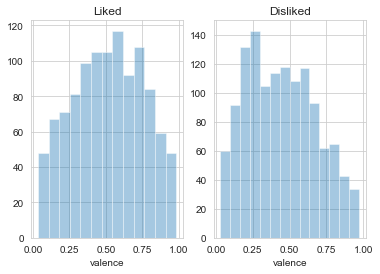

In [115]:
fig, ax =plt.subplots(1,2)
sns.distplot(liked['valence'], kde=False, ax=ax[0]).set_title("Liked")
sns.distplot(disliked['valence'], kde=False, ax=ax[1]).set_title("Disliked")
fig.show()

#### Acousticness vs. Liked

There are more liked songs that have high acousticness than there are disliked songs with high acousticness. 

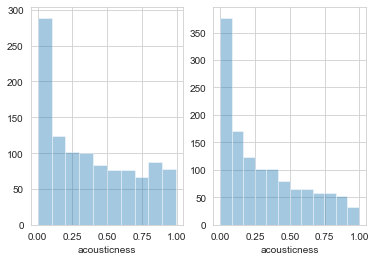

In [21]:
fig, ax =plt.subplots(1,2)
sns.distplot(liked['acousticness'], kde=False, ax=ax[0]).set_title("Liked")
sns.distplot(disliked['acousticness'], kde=False, ax=ax[1]).set_title("Disliked")
fig.show()

#### Popularity vs. Liked

There are more liked songs that have low popularity (over 200) than there are disliked songs with low popularity (just above 100). There are also many more disliked songs with average popularity (a score of 50) than there are liked songs with average popularity.

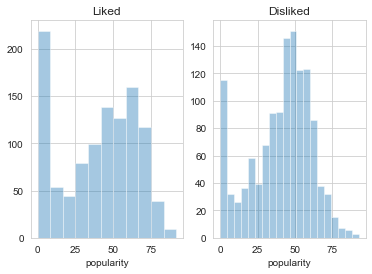

In [97]:
fig, ax =plt.subplots(1,2)
sns.distplot(liked['popularity'], kde=False, ax=ax[0]).set_title("Liked")
sns.distplot(disliked['popularity'], kde=False, ax=ax[1]).set_title("Disliked")
fig.show()

#### Tempo vs. Liked

There are more liked songs with a tempo of around 90 then there are disliked songs with a tempo of around 90. There are more disliked songs that have a tempo of 120-130 than there are liked songs of the same tempo range. 

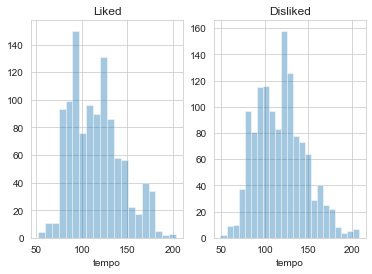

In [38]:
fig, ax =plt.subplots(1,2)
sns.distplot(liked['tempo'], kde=False, ax=ax[0]).set_title("Liked")
sns.distplot(disliked['tempo'], kde=False, ax=ax[1]).set_title("Disliked")
fig.show()

#### Duration vs. Liked

There are more outliers in terms of duration within the liked song dataset than in the disliked song dataset. 

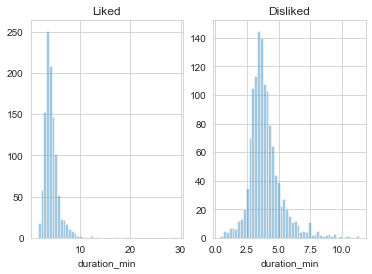

In [95]:
fig, ax =plt.subplots(1,2)
sns.distplot(liked['duration_min'], kde=False, ax=ax[0]).set_title("Liked")
sns.distplot(disliked['duration_min'], kde=False, ax=ax[1]).set_title("Disliked")
fig.show()

## Model Selection and Validation

Below is the code for three predictive models I created to analyze the relationship between the 15 features and the target variable. For the purposes of the course, I chose to use the following models: Logistic Regression, Bernoulli Naive Bayes and Decision Trees.

In [10]:
X = df.loc[:, df.columns!='like']
y = df[['like']]

In [11]:
# To create training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1896, 15) (1896, 1)
(474, 15) (474, 1)


### Logistic Regression

#### Using one training set and one test set,

In [12]:
logreg = linear_model.LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
preds = logreg.predict(X_test)
print('The accuracy score is ' + str(metrics.accuracy_score(y_test, preds)))

conf_matrix = metrics.confusion_matrix(y_test, preds, labels=[0, 1])
print(conf_matrix)

The accuracy score is 0.5864978902953587
[[179  81]
 [115  99]]


The dataframe below shows the songs, the actual like value and the predicted like value. 

In [19]:
predictions = pd.concat([X_test, y_test], axis=1)
predictions['predictions'] = preds

predictions.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,explicit,duration_min,like,predictions
2185,0.626,0.579,3,-7.558,0,0.0429,0.1040,0.00000,0.1330,0.327,127.973,4,2,1,6.289117,0,0
1819,0.550,0.294,4,-20.176,0,0.0651,0.5920,0.00000,0.2980,0.263,112.318,4,53,0,3.967733,0,1
379,0.492,0.260,9,-17.341,0,0.0921,0.6460,0.00178,0.0705,0.312,111.519,5,44,1,5.787100,1,1
211,0.674,0.441,7,-7.860,0,0.0330,0.0717,0.00000,0.1040,0.157,124.568,4,0,0,4.302000,1,0
1110,0.501,0.766,10,-4.863,0,0.0548,0.0886,0.00000,0.2400,0.225,126.057,4,40,0,3.301583,0,0


In [32]:
predicted_like = predictions.loc[predictions['predictions']==1]

predicted_like.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,explicit,duration_min,like,predictions
1819,0.550,0.294,4,-20.176,0,0.0651,0.592,0.000000,0.2980,0.263,112.318,4,53,0,3.967733,0,1
379,0.492,0.260,9,-17.341,0,0.0921,0.646,0.001780,0.0705,0.312,111.519,5,44,1,5.787100,1,1
1721,0.784,0.650,2,-5.419,0,0.0283,0.438,0.165000,0.1350,0.785,110.019,4,44,0,3.564417,0,1
2088,0.403,0.075,2,-21.393,1,0.0425,0.936,0.462000,0.2900,0.127,113.029,3,41,0,6.103333,0,1
2014,0.911,0.744,4,-7.017,0,0.2790,0.378,0.000019,0.2570,0.792,122.050,4,55,0,2.820983,0,1


#### Using cross validation

In [177]:
logreg2 = linear_model.LogisticRegression(solver='liblinear')
accs = cross_val_score(logreg2, X, y, cv=5)
print('The accuracy scores of the 5 cross-validated tests are ' + str(accs))

The accuracy scores of the 5 cross-validated tests are [0.65263158 0.67932489 0.55063291 0.56329114 0.53699789]


In [184]:
predictions = cross_val_predict(logreg2, X, y, cv=5)
r2 = metrics.r2_score(y, predictions)
mae = metrics.mean_absolute_error(y, predictions)
print('The R2 score is ' + str(r2))
print('The Mean Absolute Error is ' + str(mae))

The R2 score is -0.6253091768864811
The Mean Absolute Error is 0.40337552742616034


### Gaussian Naive Bayes

Since Gaussian NB is meant for continuous variables, I took out the three categorical feature variables for simplicity.

In [180]:
X2 = X.drop(X[['time_signature', 'mode', 'explicit']], axis=1)

# To create the training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2)
print (X_train2.shape, y_train2.shape)
print (X_test2.shape, y_test2.shape)

(1896, 12) (1896, 1)
(474, 12) (474, 1)


#### Using one training set and one test set, 

In [181]:
nb = GaussianNB()
nb.fit(X_train2, y_train2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [194]:
preds = nb.predict(X_test2)
print('The accuracy score is ' + str(metrics.accuracy_score(y_test2, preds)))

conf_matrix = metrics.confusion_matrix(y_test, preds, labels=[0, 1])
print(conf_matrix)

The accuracy score is 0.5949367088607594
[[193  67]
 [144  70]]


#### Using cross validation,

In [183]:
nb2 = GaussianNB()
accs = cross_val_score(nb2, X2, y, cv=5)
print('The accuracy scores of the 5 cross-validated tests are ' + str(accs))

The accuracy scores of the 5 cross-validated tests are [0.63368421 0.6371308  0.5464135  0.52531646 0.57082452]


In [185]:
predictions = cross_val_predict(nb2, X2, y, cv=5)
r2 = metrics.r2_score(y, predictions)
mae = metrics.mean_absolute_error(y, predictions)
print('The R2 score is ' + str(r2))
print('The Mean Absolute Error is ' + str(mae))

The R2 score is -0.6814129455446967
The Mean Absolute Error is 0.41729957805907175


### Decision Trees

#### Using one training set and one test set,

In [22]:
tree_mod = tree.DecisionTreeClassifier(max_depth=3)
tree_mod.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [23]:
preds = tree_mod.predict(X_test)
print('The accuracy score is ' + str(metrics.accuracy_score(y_test, preds)))

conf_matrix = metrics.confusion_matrix(y_test, preds, labels=[0, 1])
print(conf_matrix)

The accuracy score is 0.5759493670886076
[[175  85]
 [116  98]]


Below is a visualization of the decision tree model trained on the training set.

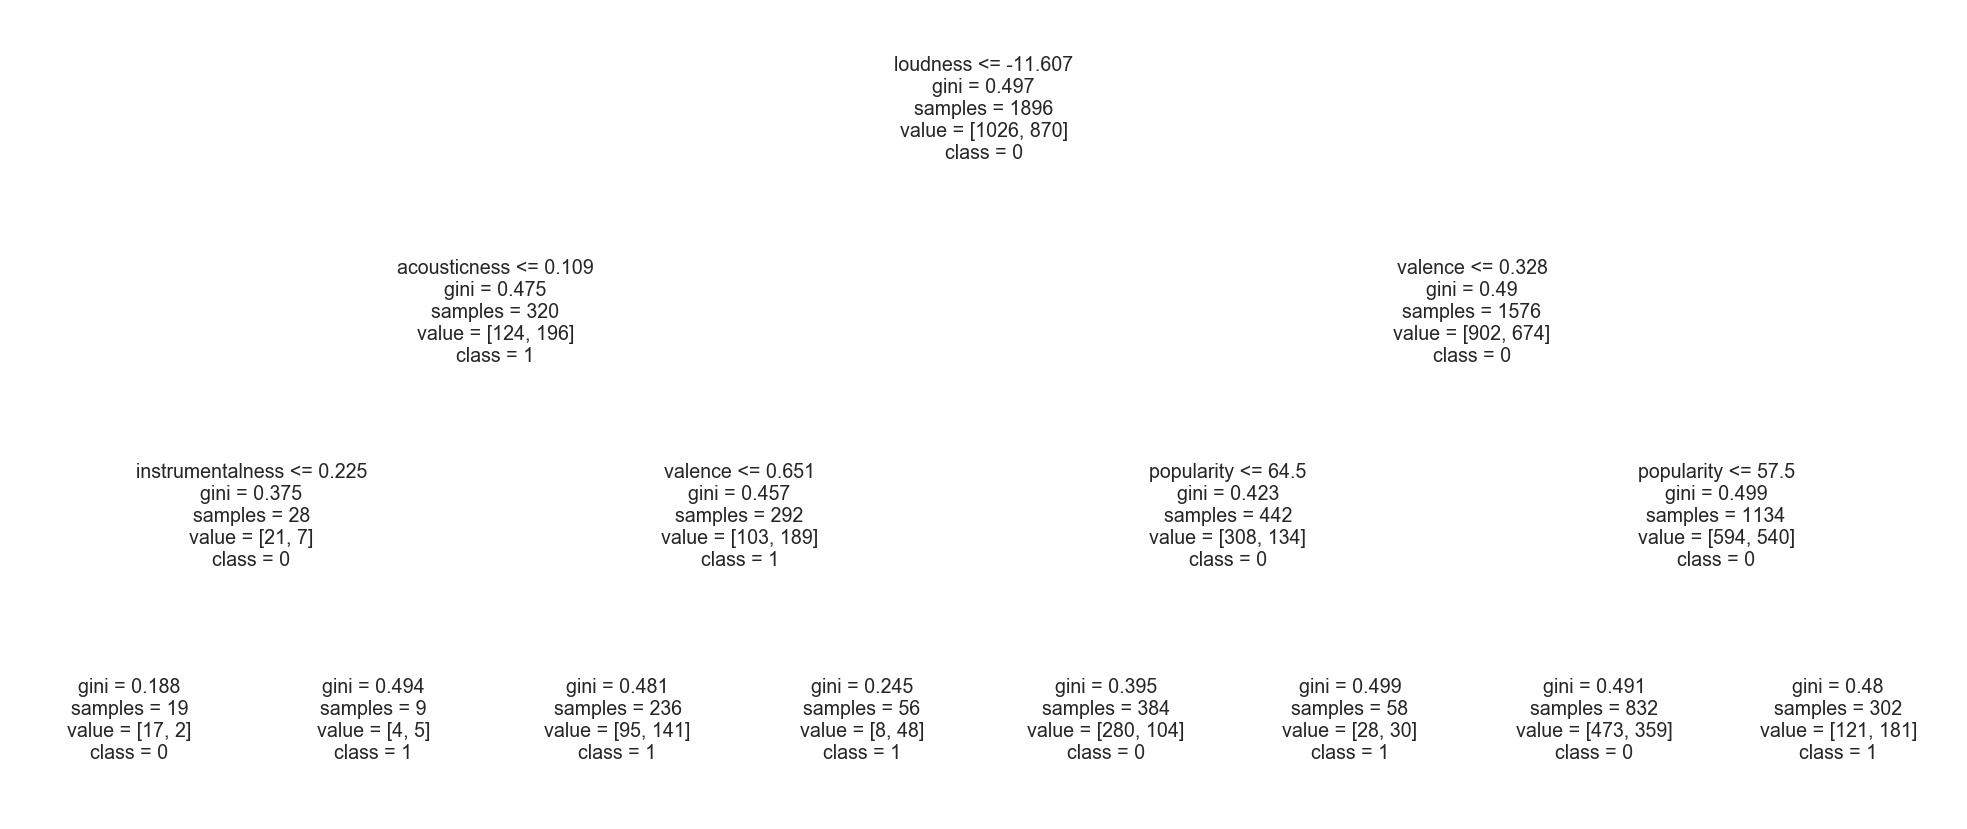

In [28]:
fig, ax = plt.subplots(figsize=(35,15))
treeplot=tree.plot_tree(tree_mod,feature_names=X_train.columns,class_names=['0','1'])

The code below shows that the depth at which the tree will perform the best (with this training/test data split) is 5.

In [30]:
for i in range(1, 10):
    tree_mod = tree.DecisionTreeClassifier(max_depth=i)
    tree_mod.fit(X_train,y_train)
    print(i, tree_mod.score(X_test,y_test))

1 0.5485232067510548
2 0.5443037974683544
3 0.5759493670886076
4 0.620253164556962
5 0.6518987341772152
6 0.6434599156118144
7 0.630801687763713
8 0.6350210970464135
9 0.6286919831223629


#### Using cross validation,

In [188]:
tree_mod2 = tree.DecisionTreeClassifier(max_depth=3)
accs = cross_val_score(tree_mod2, X, y, cv=5)
print('The accuracy scores of the 5 cross-validated tests are ' + str(accs))

The accuracy scores of the 5 cross-validated tests are [0.54526316 0.53586498 0.57172996 0.57594937 0.58985201]


In [189]:
predictions = cross_val_predict(tree_mod2, X, y, cv=5)
r2 = metrics.r2_score(y, predictions)
mae = metrics.mean_absolute_error(y, predictions)
print('The R2 score is ' + str(r2))
print('The Mean Absolute Error is ' + str(mae))

The R2 score is -0.7579180846240812
The Mean Absolute Error is 0.43628691983122364


## Results

### From the models that used a training set and a test set

Based solely on the accuracy scores of the singular tests done with each type of model, we can conclude that the Decision Tree is the most accurate model. This means that in the single test done on the Decision Tree fit with the training data, it had the highest number of correct predictions (as compared to the predictions made by the logistic regression and Gaussian NB models). 

#### Acuracy Scores

| Logistic Regression |  Gaussian Naive Bayes | Decision Tree  |
|---------------------:|:---------------------:|:---------------:|
|       0.614           |       0.595       |     0.629  |                

#### Confusion Matrices


For the **logistic regression** model:  

|                          |  Predicted 0 | Predicted 1  |
|---------------------:|:---------------------:|:---------------:|
|      **Actual 0**           |       182       |     78  |        
|      **Actual 1**           |       105       |     109  |     


For the **Gaussian NB** model:   

|                          |  Predicted 0 | Predicted 1  |
|---------------------:|:---------------------:|:---------------:|
|      **Actual 0**           |       193       |    67  |        
|      **Actual 1**           |       144       |     70  |        


For the **Decision Tree** model:

|                          |  Predicted 0 | Predicted 1  |
|---------------------:|:---------------------:|:---------------:|
|      **Actual 0**           |       191       |     69  |        
|      **Actual 1**           |      107       |     107  |        


### From the models that used 5-fold cross-validation,

A deeper look – through cross-validation and more informative metrics – indicates that the models aren't performing all that great across the board. 

Averaging the accuracy scores of a 5-fold cross validation test shows that logistic regression (not the decision tree) performs the best in predicting whether or not a song will be liked by Antoine. However, it only performs slightly better than 0.5 (or random). 

The negative R^2 values indicate that the models have low predictive ability for the outcome of liked or disliked. The R^2 values correspond with the averaged accuracy scores for each model – with the logistic regression model having the best score and the decision tree having the worst.

The Mean Absolute Value measures the average magnitude of the errors in a set of predictions. The closer the value is to 0, the fewer errors and the better. All three models have similar MAE scores, but again correspond with the averaged accuracy scores and R^2 values.

The average accuracy scores of 5-fold cross validation tests are as follows: 

| Logistic Regression |  Gaussian Naive Bayes | Decision Tree  |
|---------------------:|:---------------------:|:---------------:|
|      0.597           |       0.583       |     0.564  |   


The R^2 and Mean Absolute Error values are as follows: 

|                       | Logistic Regression |  Gaussian Naive Bayes | Decision Tree  |
|---------------------:|:---------------------:|:---------------:|-------------------|
| **R^2** |           -0.625          |       -0.681         |    -0.758              | 
| **Mean Absolute Error**      |            0.403         |        0.417        |    0.436             |    

## Conclusion

As mentioned at the start, a task such as classifying music taste is not a simple one to undertake. The models I created in this notebook were quite simplistic, and didn't take into account a whole slew of factors. Improvements I can make include proper feature selection, further model exploration, and model hyperparameter tuning. One large improvement I can also make is accounting for both numerical and categorical data witin the same model. 

There are many implications of a model that can successfully and accurately predict whether or not a person will like a song. One significant application are recommender systems – popularized in the machine learning field by the Netflix Challenge – which are used by companies like Spotify and Pandora. Understanding a listener's "music profile" will allow for a more personalized music listening experience and can change the way music discovery takes place. 